In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
import os

directories = ['../input/100-bird-species/birds_rev2/test',
                                '../input/100-bird-species/birds_rev2/train',
                                '../input/100-bird-species/birds_rev2/valid']
for dir in directories:
    label = []
    path = []
    for dirname, _,filenames in os.walk(dir):
        for filename in filenames:
            label.append(os.path.split(dirname)[1])
            path.append(os.path.join(dirname,filename))
    if dir == directories[0]:
        df_test = pd.DataFrame(columns=['path','label'])
        df_test['path']=path
        df_test['label']=label
    elif dir == directories[1]:
        df_train = pd.DataFrame(columns=['path','label'])
        df_train['path']=path
        df_train['label']=label        
    elif dir == directories[2]:
        df_valid = pd.DataFrame(columns=['path','label'])
        df_valid['path']=path
        df_valid['label']=label

# Neural Network

Changes from last notebook:
- Increased amount of image augmentation to decrease overfitting
- Decreasing learning rate as val_loss plateaus (using ReduceLROnPlateau callback)

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [11]:
image_size = (224,224)
image_shape=(224,224,3)

Found 39364 validated image filenames belonging to 275 classes.
Found 1375 validated image filenames belonging to 275 classes.
Found 1375 validated image filenames belonging to 275 classes.


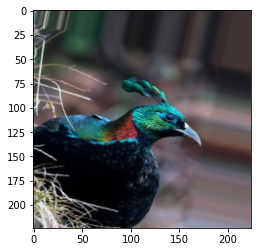

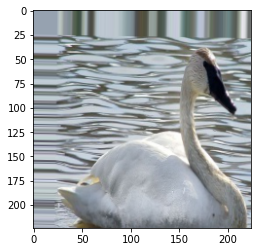

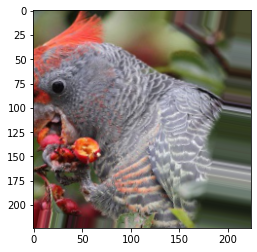

In [12]:
BS = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_valid, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

test_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_test, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

for _ in range(3):
    img, label = train_generator.next()
    plt.imshow(img[0])
    plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1950)              74881950  
_________________________________________________________________
batch_normalization_407 (Bat (None, 1950)              7800      
_________________________________________________________________
dense_3 (Dense)              (None, 275)               536525    
Total params: 129,763,011
Trainable params: 75,422,375
Non-trainable params: 54,340,636
_________________________________________________________________
Epoch 1/100
1231/1231 [==============================] - 684s 549ms/step - loss: 2.9647 - accuracy

Text(0.5, 1.0, 'Loss')

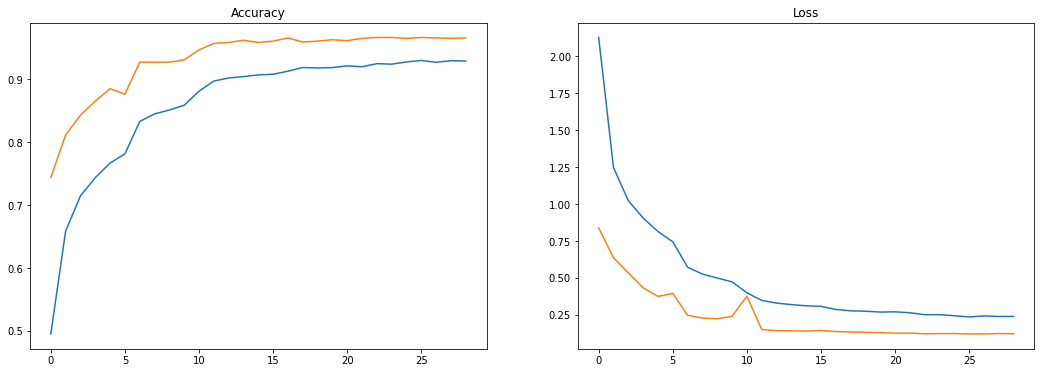

In [13]:
#model

resnet_model=tf.keras.applications.InceptionResNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
resnet_model.trainable = False


model = keras.Sequential([  
    resnet_model,
    layers.Flatten(),
    layers.Dense(units=1950,activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=275, activation="softmax"),
])
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#fit

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               restore_best_weights=True,
                               patience=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=0,
                                verbose=1)

callbacks = [early_stopping, reduce_lr]


history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    verbose=1,
    callbacks=[callbacks]
)

result=pd.DataFrame(history.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result[['loss','val_loss']])
ax[1].set_title("Loss")

In [14]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

43/43 [==============================] - 7s 143ms/step - loss: 0.1081 - accuracy: 0.9687


[0.1080966666340828, 0.9687272906303406]

In [16]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")